# Cleaning the CMS Open Payments Dataset

The [CMS Open Payments](https://openpaymentsdata.cms.gov/) dataset includes data from 2013 and 2014. We focused on the **2014 data**.


The 2014 data consists of **three .csv files** (downloaded from [here](https://www.cms.gov/OpenPayments/Explore-the-Data/Dataset-Downloads.html)). One of the csv files is quite large (CMS_open_payments_2014 general_payment_data: **10'818'054 records**; **5.68 Gb**), as shown in the [event wiki](https://github.com/WiMLDS/get_better_with_data/wiki/MySQL-dataset-descriptions).


We used MySQL queries to access subsets of the data on the database to investigate specific aspects of it. We thought an interesting approach would be to **split the file** into smaller subsets, organized according to relevant content, and create a data **schema**.


The final result would be a **database schema** allowing users to navigate a group of csv files containing realtively clean data, each of which can be loaded in memory in a typical laptop computer. This will make it easier to access and clean the data.

### List of tools used
- **MySQL** interfaces in Dataiku's **Data Science Studio** and in R ('**RMySQL**') and Python ('**pymysql**').
- **R** for most subsequent manipulations using the package '**data.table**'.

## Overall structure
Split CMS_open_payments_2014 general payment data ('OP_DTL_GNRL_PGYR2014_P06302015.csv') into five separate subsets (written to .csv files):

- Table 1: Physician
- Table 2: Physician license
- Table 3: Hospital
- Table 4: Products
- Table 5: Transaction
- Table 6: Manu/GPO info

Common key: "RecordID"

("Physician_Profile_ID" for Table 1 and Table 2)

## Procedure to produce subsets

### The example of *subset 1*
The following is the description of the first subset, as an example. We started by choosing variables to distribute between the different subsets. The following variables were chosen for the first subset:

- **Physician_Profile_ID**: Unique ID for physician receiving payment
- **Recipient_City**: City where physician primarily practices
- **Recipient_State**: State where physician primarily practices
- **Recipient_Zip_Code**: 9-digit zip code for location of physician's primary practice
- **Recipient_Country**: Country where physician primarily practices
- **Recipient_Province**: If Recipient_Country is NOT "United States": Province of physician's practice
- **Recipient_Postal_Code**: If Recipient_Country is NOT "United States": Postal code for location of practice
- **Physician_Primary_Type**: Primary type of medicine practiced by physician
- **Physician_Specialty**: Specialty of physician. Not all physicians have a specialty
- **Record_ID**: Unique ID for each financial transaction


The first step is to load the selected variables.

In [ ]:
library(data.table) # The fread() function in the data.table library is much faster than read.csv(),
                    # though it returns an object of class "data.table" rather than "data.frame"
                    # so the syntax for subsetting, etc. will be different

# Read the chosen columns of the General Payments Details .csv file
# Record_ID will serve as the primary key
# Teaching_Hospital_ID is only in the table so we can subset: it'll be deleted later on

# This table provides information on the physician involved with each financial transaction

genpay_phys <- fread("OP_DTL_GNRL_PGYR2014_P06302015.csv",
                     colClasses = c("NULL", "character", "NULL", "character", rep("NULL", 6),
                                    rep("character", 8), rep("NULL", 25), "character", 
                                    rep("NULL", 19)))

Warning message:
: package ‘data.table’ was built under R version 3.1.3

Remove records concerning payments to Teaching Hospitals (rather than physicians).

In [15]:
# Remove the 40,000-odd rows that refer to payments made to teaching hospitals
genpay_phys <- genpay_phys[Teaching_Hospital_ID == "", ]
genpay_phys[, Teaching_Hospital_ID := NULL] # Drop the Teaching_Hospital_ID column

ERROR: Error in eval(expr, envir, enclos): object 'Teaching_Hospital_ID' not found


Write subset to a new csv file (this wil be Table 1, in this example).

In [1]:
# Ad hoc function to write genpay_phys to a new .csv file, in chunks
write_genpay <- function(d) {
  for(i in 0:106) {
    write.table(d[((i * 100000) + 1):((i + 1) * 100000)], 
                "CMS 2014 General Payments Details - Physician Info.csv", append = TRUE, sep = ",", row.names = FALSE)
  }
  write.table(d[10700001:10768319, ], 
              "CMS 2014 General Payments Details - Physician Info.csv", append = TRUE, sep = ",", row.names = FALSE)
}

write_genpay(genpay_phys) # Write the physician info table to disk

Warning message:
: package ‘data.table’ was built under R version 3.1.3

ERROR: Error in fread("CMS 2014/CMS 2014 General Payments Details.csv", colClasses = c("NULL", : File is empty: /var/folders/2s/y0xzssws4m33mr9xtdwzfmk40000gn/T//Rtmpp5tKco/file15aa1e45bbb5


ERROR: Error in eval(expr, envir, enclos): object 'genpay_phys' not found


ERROR: Error in eval(expr, envir, enclos): object 'genpay_phys' not found


ERROR: Error in is.data.frame(x): object 'genpay_phys' not found


This procedure can be used to produce the six subsets/csv files, each of which can be loaded and easily handled.

### Schema

The final schema for the subsets is shown here below.

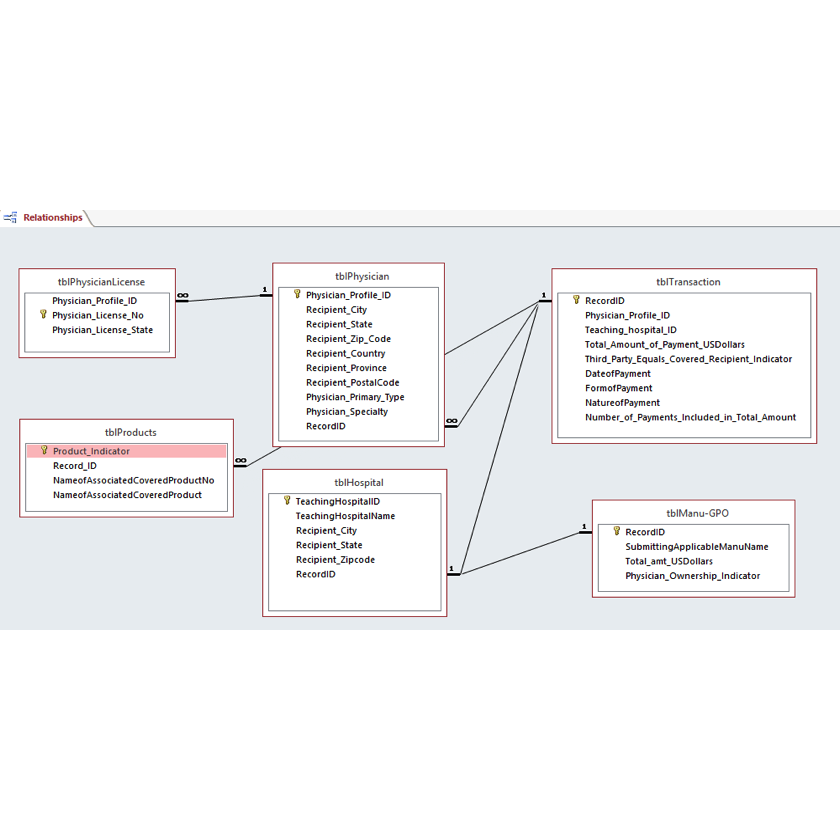

In [29]:
library(png)
schema <- readPNG('schema.png')
grid::grid.raster(schema, width = 1, height = 0.5)

## Interesting questions going forward

After cleaning the data, they can be used to answer several several interesting questions. Here are a few examples:

- **Which companies made the most payments?**

- **Which physicians received the most payments and why?**

- **Which states received the most payments?**

- **How much ownership do physicians have in Manu/GPOs?**

- **What is the dollar amount of payments made through third parties?**

- **Are any physicians/hospitals more likely to pay through 3rd parties than others?**